https://kaggle-kr.tistory.com/32<br>
https://www.kaggle.com/code/youhanlee/3250feats-532-feats-using-shap-lb-0-436/notebook#4.-Model-development

# Costa Rican Household Poverty Level Prediction
- 3250feats->532 feats using shap[LB: 0.436]

In [1]:
%pip install lightgbm xgboost shap

Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
# import shap
from tqdm import tqdm
# import featuretools as ft
import warnings 
warnings.filterwarnings('ignore')
import time

pd.set_option('display.max_rows', 150)

# 1. Check datasets

## 1.1. Read dataset

In [31]:
df_train = pd.read_csv('costarican/train.csv')
df_test = pd.read_csv('costarican/test.csv')

In [32]:
print('df_train shape:', df_train.shape, '  ', 'df_test shape: ', df_test.shape)

df_train shape: (9557, 143)    df_test shape:  (23856, 142)


In [33]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [34]:
df_train['Target'].unique()

array([4, 2, 3, 1], dtype=int64)

In [35]:
df_test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


## 1.2. Make description df

In [36]:
description = [
("v2a1"," Monthly rent payment"),
("hacdor"," =1 Overcrowding by bedrooms"),
("rooms","  number of all rooms in the house"),
("hacapo"," =1 Overcrowding by rooms"),
("v14a"," =1 has toilet in the household"),
("refrig"," =1 if the household has refrigerator"),
("v18q"," owns a tablet"),
("v18q1"," number of tablets household owns"),
("r4h1"," Males younger than 12 years of age"),
("r4h2"," Males 12 years of age and older"),
("r4h3"," Total males in the household"),
("r4m1"," Females younger than 12 years of age"),
("r4m2"," Females 12 years of age and older"),
("r4m3"," Total females in the household"),
("r4t1"," persons younger than 12 years of age"),
("r4t2"," persons 12 years of age and older"),
("r4t3"," Total persons in the household"),
("tamhog"," size of the household"),
("tamviv"," number of persons living in the household"),
("escolari"," years of schooling"),
("rez_esc"," Years behind in school"),
("hhsize"," household size"),
("paredblolad"," =1 if predominant material on the outside wall is block or brick"),
("paredzocalo"," =1 if predominant material on the outside wall is socket (wood, zinc or absbesto"),
("paredpreb"," =1 if predominant material on the outside wall is prefabricated or cement"),
("pareddes"," =1 if predominant material on the outside wall is waste material"),
("paredmad"," =1 if predominant material on the outside wall is wood"),
("paredzinc"," =1 if predominant material on the outside wall is zink"),
("paredfibras"," =1 if predominant material on the outside wall is natural fibers"),
("paredother"," =1 if predominant material on the outside wall is other"),
("pisomoscer"," =1 if predominant material on the floor is mosaic ceramic   terrazo"),
("pisocemento"," =1 if predominant material on the floor is cement"),
("pisoother"," =1 if predominant material on the floor is other"),
("pisonatur"," =1 if predominant material on the floor is  natural material"),
("pisonotiene"," =1 if no floor at the household"),
("pisomadera"," =1 if predominant material on the floor is wood"),
("techozinc"," =1 if predominant material on the roof is metal foil or zink"),
("techoentrepiso"," =1 if predominant material on the roof is fiber cement,   mezzanine "),
("techocane"," =1 if predominant material on the roof is natural fibers"),
("techootro"," =1 if predominant material on the roof is other"),
("cielorazo"," =1 if the house has ceiling"),
("abastaguadentro"," =1 if water provision inside the dwelling"),
("abastaguafuera"," =1 if water provision outside the dwelling"),
("abastaguano"," =1 if no water provision"),
("public"," =1 electricity from CNFL,  ICE, ESPH/JASEC"),
("planpri"," =1 electricity from private plant"),
("noelec"," =1 no electricity in the dwelling"),
("coopele"," =1 electricity from cooperative"),
("sanitario1"," =1 no toilet in the dwelling"),
("sanitario2"," =1 toilet connected to sewer or cesspool"),
("sanitario3"," =1 toilet connected to  septic tank"),
("sanitario5"," =1 toilet connected to black hole or letrine"),
("sanitario6"," =1 toilet connected to other system"),
("energcocinar1"," =1 no main source of energy used for cooking (no kitchen)"),
("energcocinar2"," =1 main source of energy used for cooking electricity"),
("energcocinar3"," =1 main source of energy used for cooking gas"),
("energcocinar4"," =1 main source of energy used for cooking wood charcoal"),
("elimbasu1"," =1 if rubbish disposal mainly by tanker truck"),
("elimbasu2"," =1 if rubbish disposal mainly by botan hollow or buried"),
("elimbasu3"," =1 if rubbish disposal mainly by burning"),
("elimbasu4"," =1 if rubbish disposal mainly by throwing in an unoccupied space"),
("elimbasu5"," =1 if rubbish disposal mainly by throwing in river,   creek or sea"),
("elimbasu6"," =1 if rubbish disposal mainly other"),
("epared1"," =1 if walls are bad"),
("epared2"," =1 if walls are regular"),
("epared3"," =1 if walls are good"),
("etecho1"," =1 if roof are bad"),
("etecho2"," =1 if roof are regular"),
("etecho3"," =1 if roof are good"),
("eviv1"," =1 if floor are bad"),
("eviv2"," =1 if floor are regular"),
("eviv3"," =1 if floor are good"),
("dis"," =1 if disable person"),
("male"," =1 if male"),
("female"," =1 if female"),
("estadocivil1"," =1 if less than 10 years old"),
("estadocivil2"," =1 if free or coupled uunion"),
("estadocivil3"," =1 if married"),
("estadocivil4"," =1 if divorced"),
("estadocivil5"," =1 if separated"),
("estadocivil6"," =1 if widow/er"),
("estadocivil7"," =1 if single"),
("parentesco1"," =1 if household head"),
("parentesco2"," =1 if spouse/partner"),
("parentesco3"," =1 if son/doughter"),
("parentesco4"," =1 if stepson/doughter"),
("parentesco5"," =1 if son/doughter in law"),
("parentesco6"," =1 if grandson/doughter"),
("parentesco7"," =1 if mother/father"),
("parentesco8"," =1 if father/mother in law"),
("parentesco9"," =1 if brother/sister"),
("parentesco10"," =1 if brother/sister in law"),
("parentesco11"," =1 if other family member"),
("parentesco12"," =1 if other non family member"),
("idhogar"," Household level identifier"),
("hogar_nin"," Number of children 0 to 19 in household"),
("hogar_adul"," Number of adults in household"),
("hogar_mayor"," # of individuals 65+ in the household"),
("hogar_total"," # of total individuals in the household"),
("dependency"," Dependency rate"),
("edjefe"," years of education of male head of household"),
("edjefa"," years of education of female head of household"),
("meaneduc","average years of education for adults (18+)"),
("instlevel1"," =1 no level of education"),
("instlevel2"," =1 incomplete primary"),
("instlevel3"," =1 complete primary"),
("instlevel4"," =1 incomplete academic secondary level"),
("instlevel5"," =1 complete academic secondary level"),
("instlevel6"," =1 incomplete technical secondary level"),
("instlevel7"," =1 complete technical secondary level"),
("instlevel8"," =1 undergraduate and higher education"),
("instlevel9"," =1 postgraduate higher education"),
("bedrooms"," number of bedrooms"),
("overcrowding"," # persons per room"),
("tipovivi1"," =1 own and fully paid house"),
("tipovivi2"," =1 own,   paying in installments"),
("tipovivi3"," =1 rented"),
("tipovivi4"," =1 precarious"),
("tipovivi5"," =1 other(assigned"),
("computer"," =1 if the household has notebook or desktop computer,   borrowed)"),
("television"," =1 if the household has TV"),
("mobilephone"," =1 if mobile phone"),
("qmobilephone"," # of mobile phones"),
("lugar1"," =1 region Central"),
("lugar2"," =1 region Chorotega"),
("lugar3"," =1 region PacÃƒÂ­fico central"),
("lugar4"," =1 region Brunca"),
("lugar5"," =1 region Huetar AtlÃƒÂ¡ntica"),
("lugar6"," =1 region Huetar Norte"),
("area1"," =1 zona urbana"),
("area2"," =2 zona rural"),
("age"," Age in years"),
("SQBescolari"," escolari squared"),
("SQBage"," age squared"),
("SQBhogar_total"," hogar_total squared"),
("SQBedjefe"," edjefe squared"),
("SQBhogar_nin"," hogar_nin squared"),
("SQBovercrowding"," overcrowding squared"),
("SQBdependency"," dependency squared"),
("SQBmeaned"," meaned squared"),
("agesq"," Age squared"),]

description = pd.DataFrame(description, columns=['varname', 'description'])

In [37]:
description

,varname,description
0,v2a1,Monthly rent payment
1,hacdor,=1 Overcrowding by bedrooms
2,rooms,number of all rooms in the house
3,hacapo,=1 Overcrowding by rooms
4,v14a,=1 has toilet in the household
5,refrig,=1 if the household has refrigerator
6,v18q,owns a tablet
7,v18q1,number of tablets household owns
8,r4h1,Males younger than 12 years of age
9,r4h2,Males 12 years of age and older


## 1.3. Check null data

In [38]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
SQBmeaned,5,0.052318
meaneduc,5,0.052318
Id,0,0.000000
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


In [39]:
total

rez_esc            7928
v18q1              7342
v2a1               6860
SQBmeaned             5
meaneduc              5
Id                    0
hogar_adul            0
parentesco10          0
parentesco11          0
parentesco12          0
idhogar               0
hogar_nin             0
dependency            0
hogar_mayor           0
hogar_total           0
edjefe                0
edjefa                0
instlevel1            0
instlevel2            0
parentesco9           0
parentesco7           0
parentesco8           0
estadocivil6          0
female                0
estadocivil1          0
estadocivil2          0
estadocivil3          0
estadocivil4          0
estadocivil5          0
estadocivil7          0
instlevel4            0
parentesco1           0
parentesco2           0
parentesco3           0
parentesco4           0
parentesco5           0
parentesco6           0
instlevel3            0
instlevel6            0
instlevel5            0
SQBescolari           0
lugar4          

In [40]:
percent

rez_esc            82.954902
v18q1              76.823271
v2a1               71.779847
SQBmeaned           0.052318
meaneduc            0.052318
Id                  0.000000
hogar_adul          0.000000
parentesco10        0.000000
parentesco11        0.000000
parentesco12        0.000000
idhogar             0.000000
hogar_nin           0.000000
dependency          0.000000
hogar_mayor         0.000000
hogar_total         0.000000
edjefe              0.000000
edjefa              0.000000
instlevel1          0.000000
instlevel2          0.000000
parentesco9         0.000000
parentesco7         0.000000
parentesco8         0.000000
estadocivil6        0.000000
female              0.000000
estadocivil1        0.000000
estadocivil2        0.000000
estadocivil3        0.000000
estadocivil4        0.000000
estadocivil5        0.000000
estadocivil7        0.000000
instlevel4          0.000000
parentesco1         0.000000
parentesco2         0.000000
parentesco3         0.000000
parentesco4   

## 1.4. Fill missing values

In [47]:
df_train['edjefa'].unique()

array(['no', '11', '4', '10', '9', '15', '7', '14', '13', '8', '17', '6',
       '5', '3', '16', '19', 'yes', '21', '12', '2', '20', '18'],
      dtype=object)

In [48]:
df_train['edjefe'].unique()

array(['10', '12', 'no', '11', '9', '15', '4', '6', '8', '17', '7', '16',
       '14', '5', '21', '2', '19', 'yes', '3', '18', '13', '20'],
      dtype=object)

In [50]:
# edjefe : years of education of male head of household
# edjefa : years of education of female head of household
# parentesco1 : =1 if household head
# escolari : years of schooling

# if education is "yes" and person is head of household, fill with escolari
df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "edjefa"] = df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]
df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "edjefe"] = df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]

df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "edjefa"] = df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]
df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "edjefe"] = df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]

# this field is supposed to be interaction between gender and escolari, but it isn't clear what "yes" means, let's fill it with 4
df_train.loc[df_train['edjefa'] == "yes", "edjefa"] = 4
df_train.loc[df_train['edjefe'] == "yes", "edjefe"] = 4

df_test.loc[df_test['edjefa'] == "yes", "edjefa"] = 4
df_test.loc[df_test['edjefe'] == "yes", "edjefe"] = 4

# create feature with max education of either head of household
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

# fix some inconsistencies in the data - some rows indicate both that the household does and does not have a toilet, 
# if there is no water we'll assume they do not
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "v14a"] = 0
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "sanitario1"] = 0

df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "v14a"] = 0
df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "sanitario1"] = 0

### rez_esz, SQBmeaned

* rez_esc: Years behind in school --> filled with 0
* SQBmeaned: square of the mean years of education of adults(>=18) in the household agesq, Age sqaured --> same with rez_esc --> filled with 0

In [51]:
df_train['rez_esc'].fillna(0, inplace=True)
df_test['rez_esc'].fillna(0, inplace=True)

In [52]:
df_train['SQBmeaned'].fillna(0, inplace=True)
df_test['SQBmeaned'].fillna(0, inplace=True)

### meaneduc

* meaneduc: average years of education for adults (18+) -> filled with 0

In [53]:
df_train['meaneduc'].fillna(0, inplace=True)
df_test['meaneduc'].fillna(0, inplace=True)

### v18q1

* v18q1: number of tablets household owns -> if v18q(Do you own a tablet?) == 1, there are some values. If not, only NaN values in v18q1. See below 3 cells.

In [54]:
df_train['v18q'].value_counts()

0    7342
1    2215
Name: v18q, dtype: int64

* v18q1: number of tablets household owns -> if v18q == 1, there are some values. If not, only NaN values there. See below two cells.

In [55]:
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [56]:
df_train.loc[df_train['v18q'] == 0, 'v18q1'].value_counts()

Series([], Name: v18q1, dtype: int64)

In [57]:
df_train['v18q1'].fillna(0, inplace=True)
df_test['v18q1'].fillna(0, inplace=True)

* v2a1: number of tablets household owns -> if tipovivi3(rented?) == 1, there are some values. If not, there are also some values.
* NaN value could be replaced by 0.

In [58]:
df_train['tipovivi3'].value_counts()

0    7821
1    1736
Name: tipovivi3, dtype: int64

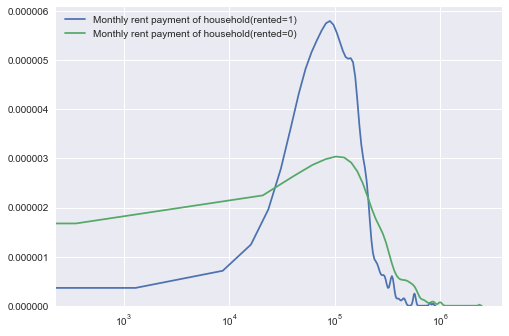

In [59]:
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 1, 'v2a1'], label='Monthly rent payment of household(rented=1)')
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 0, 'v2a1'], label='Monthly rent payment of household(rented=0)')
plt.xscale('log')
plt.show()

In [60]:
df_train['v2a1'].fillna(0, inplace=True)
df_test['v2a1'].fillna(0, inplace=True)

In [61]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,9557,100.0
v2a1,0,0.0
parentesco10,0,0.0
parentesco11,0,0.0
parentesco12,0,0.0
idhogar,0,0.0
hogar_nin,0,0.0
hogar_adul,0,0.0
hogar_mayor,0,0.0
hogar_total,0,0.0


In [63]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,23856,100.0
hogar_mayor,0,0.0
parentesco10,0,0.0
parentesco11,0,0.0
parentesco12,0,0.0
idhogar,0,0.0
hogar_nin,0,0.0
hogar_adul,0,0.0
hogar_total,0,0.0
parentesco8,0,0.0


# 2. Feature engineering

## 2.1. Object features

In [64]:
features_object = [col for col in df_train.columns if df_train[col].dtype == 'object']

In [65]:
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

### dependency

In [66]:
# some dependencies are Na, fill those with the square root of the square
df_train['dependency'] = np.sqrt(df_train['SQBdependency'])
df_test['dependency'] = np.sqrt(df_test['SQBdependency'])

In [67]:
# df_train['dependency'] = df_train['dependency'].replace({np.inf: 0})
# df_test['dependency'] = df_test['dependency'].replace({np.inf: 0})

# def replace_dependency(x):
#     if x == 'yes':
#         return 10
#     elif x == 'no':
#         return 0
#     else:
#         return x

# df_train['dependency'] = df_train['dependency'].apply(replace_dependency).astype(float)
# df_test['dependency'] = df_test['dependency'].apply(replace_dependency).astype(float)

# - As you can see, setting yes -> 10 and no -> 0 is good choice.
# - At first, fill inf value with 0.

### edjefe

* edjefe, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* replace yes -> 1 and no -> 0

In [68]:
def replace_edjefe(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefe'] = df_train['edjefe'].apply(replace_edjefe).astype(float)
df_test['edjefe'] = df_test['edjefe'].apply(replace_edjefe).astype(float)

### edjefa

* edjefa, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* replace yes -> 1 and no -> 0

In [69]:
def replace_edjefa(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefa'] = df_train['edjefa'].apply(replace_edjefa).astype(float)
df_test['edjefa'] = df_test['edjefa'].apply(replace_edjefa).astype(float)

In [70]:
# create feature with max education of either head of household
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

### roof and electricity

In [72]:
df_train['roof_waste_material'] = np.nan
df_test['roof_waste_material'] = np.nan
df_train['electricity_other'] = np.nan
df_test['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0

df_train['roof_waste_material'] = df_train.apply(lambda x : fill_roof_exception(x),axis=1)
df_test['roof_waste_material'] = df_test.apply(lambda x : fill_roof_exception(x),axis=1)
df_train['electricity_other'] = df_train.apply(lambda x : fill_no_electricity(x),axis=1)
df_test['electricity_other'] = df_test.apply(lambda x : fill_no_electricity(x),axis=1)

## 2.2 Extract cat features

* According to data scription, there are many binary category features.

In [73]:
binary_cat_features = [col for col in df_train.columns if df_train[col].value_counts().shape[0] == 2]

In [74]:
binary_cat_features

['hacdor',
 'hacapo',
 'v14a',
 'refrig',
 'v18q',
 'paredblolad',
 'paredzocalo',
 'paredpreb',
 'pareddes',
 'paredmad',
 'paredzinc',
 'paredfibras',
 'paredother',
 'pisomoscer',
 'pisocemento',
 'pisoother',
 'pisonatur',
 'pisonotiene',
 'pisomadera',
 'techozinc',
 'techoentrepiso',
 'techocane',
 'techootro',
 'cielorazo',
 'abastaguadentro',
 'abastaguafuera',
 'abastaguano',
 'public',
 'planpri',
 'noelec',
 'coopele',
 'sanitario1',
 'sanitario2',
 'sanitario3',
 'sanitario5',
 'sanitario6',
 'energcocinar1',
 'energcocinar2',
 'energcocinar3',
 'energcocinar4',
 'elimbasu1',
 'elimbasu2',
 'elimbasu3',
 'elimbasu4',
 'elimbasu6',
 'epared1',
 'epared2',
 'epared3',
 'etecho1',
 'etecho2',
 'etecho3',
 'eviv1',
 'eviv2',
 'eviv3',
 'dis',
 'male',
 'female',
 'estadocivil1',
 'estadocivil2',
 'estadocivil3',
 'estadocivil4',
 'estadocivil5',
 'estadocivil6',
 'estadocivil7',
 'parentesco1',
 'parentesco2',
 'parentesco3',
 'parentesco4',
 'parentesco5',
 'parentesco6',
 'pa

## 2.3 Make new features using continuous feature

In [75]:
continuous_features = [col for col in df_train.columns if col not in binary_cat_features]
continuous_features = [col for col in continuous_features if col not in features_object]
continuous_features = [col for col in continuous_features if col not in ['Id', 'Target', 'idhogar']]

In [76]:
continuous_features

['v2a1',
 'rooms',
 'v18q1',
 'r4h1',
 'r4h2',
 'r4h3',
 'r4m1',
 'r4m2',
 'r4m3',
 'r4t1',
 'r4t2',
 'r4t3',
 'tamhog',
 'tamviv',
 'escolari',
 'rez_esc',
 'hhsize',
 'elimbasu5',
 'hogar_nin',
 'hogar_adul',
 'hogar_mayor',
 'hogar_total',
 'meaneduc',
 'bedrooms',
 'overcrowding',
 'qmobilephone',
 'age',
 'SQBescolari',
 'SQBage',
 'SQBhogar_total',
 'SQBedjefe',
 'SQBhogar_nin',
 'SQBovercrowding',
 'SQBdependency',
 'SQBmeaned',
 'agesq',
 'edjef']

In [77]:
print('There are {} continuous features'.format(len(continuous_features)))
for col in continuous_features:
    print('{}: {}'.format(col, description.loc[description['varname'] == col, 'description'].values))

There are 37 continuous features
v2a1: [' Monthly rent payment']
rooms: ['  number of all rooms in the house']
v18q1: [' number of tablets household owns']
r4h1: [' Males younger than 12 years of age']
r4h2: [' Males 12 years of age and older']
r4h3: [' Total males in the household']
r4m1: [' Females younger than 12 years of age']
r4m2: [' Females 12 years of age and older']
r4m3: [' Total females in the household']
r4t1: [' persons younger than 12 years of age']
r4t2: [' persons 12 years of age and older']
r4t3: [' Total persons in the household']
tamhog: [' size of the household']
tamviv: [' number of persons living in the household']
escolari: [' years of schooling']
rez_esc: [' Years behind in school']
hhsize: [' household size']
elimbasu5: [' =1 if rubbish disposal mainly by throwing in river,   creek or sea']
hogar_nin: [' Number of children 0 to 19 in household']
hogar_adul: [' Number of adults in household']
hogar_mayor: [' # of individuals 65+ in the household']
hogar_total: [

* As you can see, the meaning of two features are same but the exact number are different. Are they different?
* I don't know. For now, I decided to drop one feature 'tamhog'.

In [78]:
df_train['edjef'].value_counts()

6.0     2792
11.0    1150
9.0      723
8.0      474
15.0     473
3.0      459
0.0      435
7.0      413
4.0      400
5.0      398
14.0     328
17.0     278
2.0      278
16.0     247
10.0     207
12.0     185
13.0     155
1.0       65
21.0      48
18.0      22
19.0      18
20.0       9
Name: edjef, dtype: int64

In [79]:
df_train.drop('tamhog', axis=1, inplace=True)
df_test.drop('tamhog', axis=1, inplace=True)

## Squared features

* There are many squared features. Actually, tree models like lightgbm don't need them. But at this kernel, I want to use lightgbm as feature filter model and set entity- embedding as classfier. So Let's keep them.

## Family features

* hogar_nin, hogar_adul, hogar_mayor, hogar_total, r4h1, r4h2, r4h3, r4m1, r4m2, r4m3, r4t1, r4t2, r4t3, tmbhog, tamvid, rez_esc, escolari

* Family size features (substract, ratio)

In [80]:
df_train['adult'] = df_train['hogar_adul'] - df_train['hogar_mayor']
df_train['dependency_count'] = df_train['hogar_nin'] + df_train['hogar_mayor']
df_train['dependency'] = df_train['dependency_count'] / df_train['adult']
df_train['child_percent'] = df_train['hogar_nin'] / df_train['hogar_total']
df_train['elder_percent'] = df_train['hogar_mayor'] / df_train['hogar_total']
df_train['adult_percent'] = df_train['hogar_adul'] / df_train['hogar_total']
df_train['males_younger_12_years_percent'] = df_train['r4h1'] / df_train['hogar_total']
df_train['males_older_12_years_percent'] = df_train['r4h2'] / df_train['hogar_total']
df_train['males_percent'] = df_train['r4h3'] / df_train['hogar_total']
df_train['females_younger_12_years_percent'] = df_train['r4m1'] / df_train['hogar_total']
df_train['females_older_12_years_percent'] = df_train['r4m2'] / df_train['hogar_total']
df_train['females_percent'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_percent'] = df_train['r4t1'] / df_train['hogar_total']
df_train['persons_older_12_years_percent'] = df_train['r4t2'] / df_train['hogar_total']
df_train['persons_percent'] = df_train['r4t3'] / df_train['hogar_total']

In [81]:
df_test['adult'] = df_test['hogar_adul'] - df_test['hogar_mayor']
df_test['dependency_count'] = df_test['hogar_nin'] + df_test['hogar_mayor']
df_test['dependency'] = df_test['dependency_count'] / df_test['adult']
df_test['child_percent'] = df_test['hogar_nin'] / df_test['hogar_total']
df_test['elder_percent'] = df_test['hogar_mayor'] / df_test['hogar_total']
df_test['adult_percent'] = df_test['hogar_adul'] / df_test['hogar_total']
df_test['males_younger_12_years_percent'] = df_test['r4h1'] / df_test['hogar_total']
df_test['males_older_12_years_percent'] = df_test['r4h2'] / df_test['hogar_total']
df_test['males_percent'] = df_test['r4h3'] / df_test['hogar_total']
df_test['females_younger_12_years_percent'] = df_test['r4m1'] / df_test['hogar_total']
df_test['females_older_12_years_percent'] = df_test['r4m2'] / df_test['hogar_total']
df_test['females_percent'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_percent'] = df_test['r4t1'] / df_test['hogar_total']
df_test['persons_older_12_years_percent'] = df_test['r4t2'] / df_test['hogar_total']
df_test['persons_percent'] = df_test['r4t3'] / df_test['hogar_total']

In [82]:
df_train['males_younger_12_years_in_household_size'] = df_train['r4h1'] / df_train['hhsize']
df_train['males_older_12_years_in_household_size'] = df_train['r4h2'] / df_train['hhsize']
df_train['males_in_household_size'] = df_train['r4h3'] / df_train['hhsize']
df_train['females_younger_12_years_in_household_size'] = df_train['r4m1'] / df_train['hhsize']
df_train['females_older_12_years_in_household_size'] = df_train['r4m2'] / df_train['hhsize']
df_train['females_in_household_size'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_in_household_size'] = df_train['r4t1'] / df_train['hhsize']
df_train['persons_older_12_years_in_household_size'] = df_train['r4t2'] / df_train['hhsize']
df_train['persons_in_household_size'] = df_train['r4t3'] / df_train['hhsize']

In [83]:
df_test['males_younger_12_years_in_household_size'] = df_test['r4h1'] / df_test['hhsize']
df_test['males_older_12_years_in_household_size'] = df_test['r4h2'] / df_test['hhsize']
df_test['males_in_household_size'] = df_test['r4h3'] / df_test['hhsize']
df_test['females_younger_12_years_in_household_size'] = df_test['r4m1'] / df_test['hhsize']
df_test['females_older_12_years_in_household_size'] = df_test['r4m2'] / df_test['hhsize']
df_test['females_in_household_size'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_in_household_size'] = df_test['r4t1'] / df_test['hhsize']
df_test['persons_older_12_years_in_household_size'] = df_test['r4t2'] / df_test['hhsize']
df_test['persons_in_household_size'] = df_test['r4t3'] / df_test['hhsize']

In [84]:
df_train['overcrowding_room_and_bedroom'] = (df_train['hacdor'] + df_train['hacapo'])/2
df_test['overcrowding_room_and_bedroom'] = (df_test['hacdor'] + df_test['hacapo'])/2

In [85]:
df_train['escolari_age'] = df_train['escolari']/df_train['age']
df_test['escolari_age'] = df_test['escolari']/df_test['age']

df_train['age_12_19'] = df_train['hogar_nin'] - df_train['r4t1']
df_test['age_12_19'] = df_test['hogar_nin'] - df_test['r4t1']  

In [86]:
df_train['phones-per-capita'] = df_train['qmobilephone'] / df_train['tamviv']
df_train['tablets-per-capita'] = df_train['v18q1'] / df_train['tamviv']
df_train['rooms-per-capita'] = df_train['rooms'] / df_train['tamviv']
df_train['rent-per-capita'] = df_train['v2a1'] / df_train['tamviv']

In [87]:
df_test['phones-per-capita'] = df_test['qmobilephone'] / df_test['tamviv']
df_test['tablets-per-capita'] = df_test['v18q1'] / df_test['tamviv']
df_test['rooms-per-capita'] = df_test['rooms'] / df_test['tamviv']
df_test['rent-per-capita'] = df_test['v2a1'] / df_test['tamviv']

* You can see that "Total persons in the household" != "# of total individuals in the household".
* Somewhat weired. But for now I will keep it.

In [88]:
(df_train['hogar_total'] == df_train['r4t3']).sum()

9509

### Rent per family features

* I will reduce the number of features using shap, so let's generate many features!! Hope catch some fortune features :)

In [89]:
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v2a1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v2a1'] / df_train[col]
    df_test[new_col_name] = df_test['v2a1'] / df_test[col]

* Ratio feature can have infinite values. So Let them be filled with 0

In [90]:
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

### Room per family features

In [91]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rooms'] / df_train[col]
    df_test[new_col_name] = df_test['rooms'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

### BedRoom per family features

In [92]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('bedrooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['bedrooms'] / df_train[col]
    df_test[new_col_name] = df_test['bedrooms'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [93]:
print(df_train.shape, df_test.shape) # To check the same number of features between train and test (target is there in train)

(9557, 220) (23856, 219)


(...making...)